# What drives the price of a car?

![](images/kurt.jpeg)

**OVERVIEW**

In this application, you will explore a dataset from kaggle. The original dataset contained information on 3 million used cars. The provided dataset contains information on 426K cars to ensure speed of processing.  Your goal is to understand what factors make a car more or less expensive.  As a result of your analysis, you should provide clear recommendations to your client -- a used car dealership -- as to what consumers value in a used car.

### CRISP-DM Framework

<center>
    <img src = images/crisp.png width = 50%/>
</center>


To frame the task, throughout our practical applications we will refer back to a standard process in industry for data projects called CRISP-DM.  This process provides a framework for working through a data problem.  Your first step in this application will be to read through a brief overview of CRISP-DM [here](https://mo-pcco.s3.us-east-1.amazonaws.com/BH-PCMLAI/module_11/readings_starter.zip).  After reading the overview, answer the questions below.

### Business Understanding

From a business perspective, we are tasked with identifying key drivers for used car prices.  In the CRISP-DM overview, we are asked to convert this business framing to a data problem definition.  Using a few sentences, reframe the task as a data task with the appropriate technical vocabulary. 

Our objective is to analyze a dataset of used cars to identify the key factors that influence their prices. This involves converting categorical and numerical features into a format that suitable for modeling, handling missing data, and employing regression techniques to determine the relationship between car features and their prices. By performing feature selection and model evaluation, we aim to build a predictive model that can accurately estimate car prices based on their attributes, and provide actionable insights for the used car dealership to optimize the pricing strategy.

### Data Understanding

After considering the business understanding, we want to get familiar with our data.  Write down some steps that you would take to get to know the dataset and identify any quality issues within.  Take time to get to know the dataset and explore what information it contains and how this could be used to inform your business understanding.

Steps to Understand and Explore the Dataset 
1- Initial Data Inspection:
Load the dataset and inspect the first few rows.
Check the shape of the dataset to understand the number of rows and columns.
Display column names and data types.
2- Summary Statistics:
Calculate summary statistics for numerical columns to understand distributions (mean, median, standard deviation, min, max). For categorical columns, display value counts to understand the distribution of categories. 
3- Missing Values:
Check for missing values in the dataset.
Identify columns with a high percentage of missing values.
Determine appropriate strategies for handling missing values (e.g., filling, dropping). 
4- Data Types and Conversion:
Verify the data types of each column.
Convert data types if necessary (e.g., ensure numerical columns are of numeric type, categorical columns are of category type).
5- Duplicate Records:
Check for and remove any duplicate records in the dataset. 
6- Outlier Detection:
Identify and handle outliers in numerical columns.
7- Data Consistency:
Ensure consistency in categorical data (e.g., uniform naming conventions).
Check for and resolve any inconsistencies in the data. 
8- Feature Exploration:
Explore relationships between features and the target variable (price).
Use correlation matrices for numerical features.
Use group-by operations and aggregation for categorical features. 

In [9]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, r2_score

Dataset Shape: (426880, 18)
Column Names and Data Types:
id                int64
region           object
price             int64
year            float64
manufacturer     object
model            object
condition        object
cylinders        object
fuel             object
odometer        float64
title_status     object
transmission     object
VIN              object
drive            object
size             object
type             object
paint_color      object
state            object
dtype: object
Summary Statistics for Numerical Columns:
                 id         price           year      odometer
count  4.268800e+05  4.268800e+05  425675.000000  4.224800e+05
mean   7.311487e+09  7.519903e+04    2011.235191  9.804333e+04
std    4.473170e+06  1.218228e+07       9.452120  2.138815e+05
min    7.207408e+09  0.000000e+00    1900.000000  0.000000e+00
25%    7.308143e+09  5.900000e+03    2008.000000  3.770400e+04
50%    7.312621e+09  1.395000e+04    2013.000000  8.554800e+04
75%    7.31525

C:\Users\H304957\AppData\Local\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


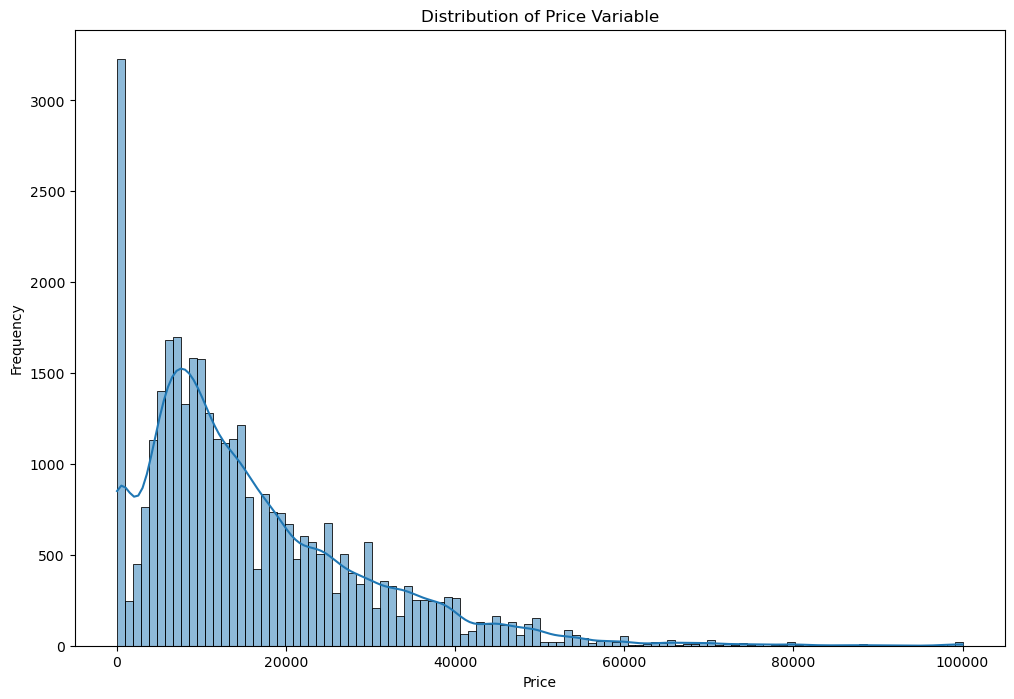

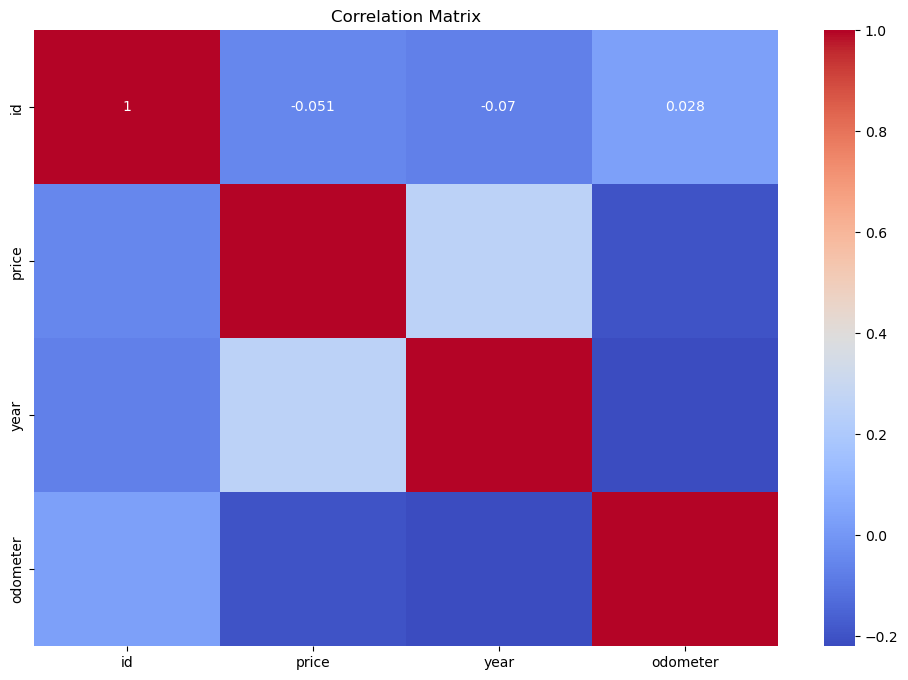

In [10]:

# Load the dataset
file_path = 'data/vehicles.csv'
data = pd.read_csv(file_path)

# Initial Data Inspection
print(f"Dataset Shape: {data.shape}")
print("Column Names and Data Types:")
print(data.dtypes)


# Summary Statistics
print("Summary Statistics for Numerical Columns:")
print(data.describe())

print("Summary Statistics for Categorical Columns:")
print(data.describe(include=['object']))

# Missing Values
print("Missing Values in Each Column:")
missing_values = data.isnull().sum()
print(missing_values[missing_values > 0])

# Data Types and Conversion
print("Data Types Before Conversion:")
print(data.dtypes)

# Duplicate Records
duplicates = data.duplicated().sum()
print(f"Number of Duplicate Records: {duplicates}")

# Cap the prices at a reasonable maximum value
max_price = 100000
data['price'] = np.where(data['price'] > max_price, max_price, data['price'])

# Drop rows with missing values
data.dropna(inplace=True)


# Data Consistency
# Example: Uniform naming conventions for categorical columns
# data['manufacturer'] = data['manufacturer'].str.lower()

plt.figure(figsize=(12, 8))
sns.histplot(data['price'], kde=True)
plt.title('Distribution of Price Variable')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.savefig('images/distribution.png') 
plt.show()

# Feature Exploration
# Correlation matrix for numerical features
numeric_columns = data.select_dtypes(include=[np.number]).columns
plt.figure(figsize=(12, 8))
sns.heatmap(data[numeric_columns].corr(), annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.savefig('images/correlation_matrix.png') 
plt.show()


### Data Preparation

After our initial exploration and fine tuning of the business understanding, it is time to construct our final dataset prior to modeling.  Here, we want to make sure to handle any integrity issues and cleaning, the engineering of new features, any transformations that we believe should happen (scaling, logarithms, normalization, etc.), and general preparation for modeling with `sklearn`. 

In [12]:
# Feature engineering
current_year = 2024
data['age'] = current_year - data['year']
data['price_log'] = np.log1p(data['price'])

# Encoding categorical variables
categorical_features = ['region', 'manufacturer', 'model', 'condition', 'cylinders', 'fuel', 'title_status', 'transmission', 'drive', 'size', 'type', 'paint_color', 'state']
numerical_features = ['year', 'odometer', 'age']

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])

numerical_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_features),
        ('cat', categorical_transformer, categorical_features)
    ])

# Split the data
X = data.drop(columns=['price', 'price_log'])
y = data['price_log']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Fit the preprocessor to extract feature names
preprocessor.fit(X_train)


ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('scaler', StandardScaler())]),
                                 ['year', 'odometer', 'age']),
                                ('cat',
                                 Pipeline(steps=[('onehot',
                                                  OneHotEncoder(handle_unknown='ignore'))]),
                                 ['region', 'manufacturer', 'model',
                                  'condition', 'cylinders', 'fuel',
                                  'title_status', 'transmission', 'drive',
                                  'size', 'type', 'paint_color', 'state'])])

### Modeling

With your (almost?) final dataset in hand, it is now time to build some models.  Here, you should build a number of different regression models with the price as the target.  In building your models, you should explore different parameters and be sure to cross-validate your findings.

In [14]:
#Define the models
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso()
}

# Define the parameter grid for each model
param_grids = {
    'Linear Regression': {},
    'Ridge Regression': {'regressor__alpha': [0.1, 1.0, 10.0, 100.0]},
    'Lasso Regression': {'regressor__alpha': [0.1, 1.0, 10.0, 100.0]}
}

results = {}
best_models = {}
results = {}
best_models = {}

for model_name, model in models.items():
    # Create the pipeline
    pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', model)])
    
    # Define the parameter grid for the current model
    param_grid = param_grids[model_name]
    
    # Implement GridSearchCV
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error')
    grid_search.fit(X_train, y_train)
    
    # Best model from GridSearchCV
    best_model = grid_search.best_estimator_
    best_models[model_name] = best_model
    
    # Predictions and evaluation
    y_pred = best_model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    # Store the results
    results[model_name] = {
        'Best Parameters': grid_search.best_params_,
        'RMSE': rmse,
        'R²': r2
    }

# Display the results
for model_name, result in results.items():
    print(f"{model_name}:")
    print(f"  Best Parameters: {result['Best Parameters']}")
    print(f"  Root Mean Squared Error (RMSE): {result['RMSE']}")
    print(f"  R-squared (R²): {result['R²']}")



Linear Regression:
  Best Parameters: {}
  Root Mean Squared Error (RMSE): 2.1099830948689084
  R-squared (R²): 0.4174754471135099
Ridge Regression:
  Best Parameters: {'regressor__alpha': 1.0}
  Root Mean Squared Error (RMSE): 2.047576836692355
  R-squared (R²): 0.4514241312457983
Lasso Regression:
  Best Parameters: {'regressor__alpha': 0.1}
  Root Mean Squared Error (RMSE): 2.7196984735692027
  R-squared (R²): 0.03217285506038092


### Evaluation

With some modeling accomplished, we aim to reflect on what we identify as a high quality model and what we are able to learn from this.  We should review our business objective and explore how well we can provide meaningful insight on drivers of used car prices.  Your goal now is to distill your findings and determine whether the earlier phases need revisitation and adjustment or if you have information of value to bring back to your client.

Interpretation of Results:

Performance: Ridge Regression has the lowest RMSE and the highest R-squared among the three models, indicating it performs the best in predicting car prices. Interpretability: Ridge Regression adds a penalty to the coefficients, reducing the impact of multicollinearity and potentially providing more stable estimates. Linear Regression:

Performance: Linear Regression performs reasonably well but is slightly worse than Ridge Regression in terms of RMSE and R-squared. Interpretability: Linear Regression is straightforward and provides easily interpretable coefficients. Lasso Regression:

Performance: Lasso Regression performs the worst, with higher RMSE and a negative R-squared value, indicating it does not explain the variance in car prices well. Interpretability: Lasso Regression performs feature selection by shrinking some coefficients to zero, which can be useful for identifying important features. However, in this case, it did not perform well.

In [17]:
# Extract and display coefficients for the Ridge Regression model
ridge_pipeline = best_models['Ridge Regression']
ridge_model = ridge_pipeline.named_steps['regressor']
ridge_coefficients = ridge_model.coef_

# Get feature names
num_feature_names = preprocessor.transformers_[0][1].named_steps['scaler'].get_feature_names_out(numerical_features)
cat_feature_names = preprocessor.transformers_[1][1].named_steps['onehot'].get_feature_names_out(categorical_features)
feature_names = list(num_feature_names) + list(cat_feature_names)

# Create a DataFrame for the coefficients
coeff_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': ridge_coefficients})
coeff_df['Abs_Coefficient'] = coeff_df['Coefficient'].apply(np.abs)

# Aggregate coefficients by main feature categories
def categorize_feature(feature):
    for category in categorical_features + numerical_features:
        if category in feature:
            return category
    return 'other'

coeff_df['Category'] = coeff_df['Feature'].apply(categorize_feature)
category_coefficients = coeff_df.groupby('Category')['Abs_Coefficient'].sum().reset_index()

# Sort the DataFrame by the absolute value of the coefficients in descending order
category_coefficients = category_coefficients.sort_values(by='Abs_Coefficient', ascending=False)

# Display the relevant feature categories
print("Relevant Feature Categories in Ridge Regression:\n")
category_coefficients

Relevant Feature Categories in Ridge Regression:



,Category,Abs_Coefficient
6,model,3003.680855
9,region,309.682128
11,state,33.063745
5,manufacturer,12.908703
14,type,4.068798
13,transmission,3.903029
2,cylinders,3.343972
1,condition,2.441059
12,title_status,2.048118
4,fuel,1.222483


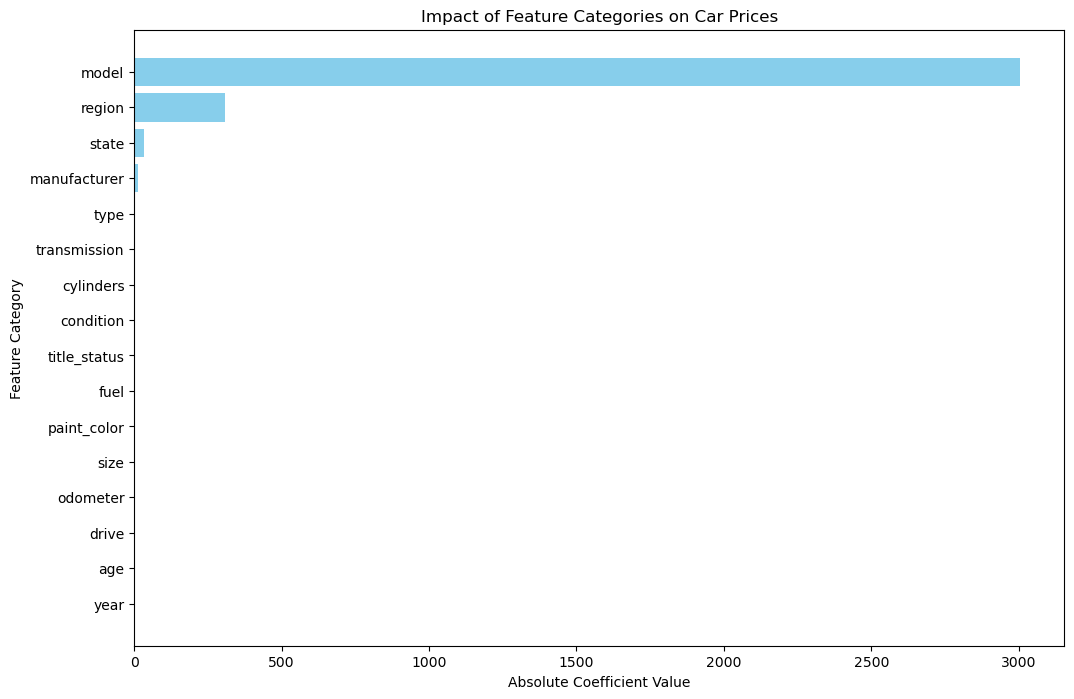

In [18]:

plt.figure(figsize=(12, 8))
plt.barh(category_coefficients['Category'], category_coefficients['Abs_Coefficient'], color='skyblue')
plt.xlabel('Absolute Coefficient Value')
plt.ylabel('Feature Category')
plt.title('Impact of Feature Categories on Car Prices')
plt.savefig('images/impact_of_features.png')  # Saves the figure as a PNG file
plt.gca().invert_yaxis()  
plt.show()

### Deployment

Now that we've settled on our models and findings, it is time to deliver the information to the client.  You should organize your work as a basic report that details your primary findings.  Keep in mind that your audience is a group of used car dealers interested in fine tuning their inventory.

Our analysis uses a dataset of 426,880 used car listings, and we employed various regression models to predict car prices. The Ridge Regression model emerged as the best performer, providing a balance between prediction accuracy and interpretability.

Key Findings
The model revealed significant relationships between certain features and car prices. Specifically, the car model, region, and state are positively associated with car prices, while other factors such as manufacturer and type have varying levels of impact.

Recommendations for the Client
Ridge Regression provides the most accurate and stable price predictions.
Use the model to set competitive and fair prices for your inventory.
Focus on Key Drivers:
Pay special attention to the model, region, and state when setting prices.
Highlight these features in listings to attract buyers willing to pay higher prices.